### Importing required libraries

In [156]:
%matplotlib inline

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
import scipy.stats as stats

from sklearn.metrics import jaccard_similarity_score
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

### Utilities

In [164]:
def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def jaccard_distance(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return 1 - intersection_cardinality/float(union_cardinality)

def tanimoto(X, W, b=None):
    """ Tanimoto similarity function """
    XW = X.dot(W.T)
    XX = np.abs(X).sum().reshape((-1, 1))
    WW = np.abs(W).sum().reshape((1, -1))
    return XW / (XX+WW-XW)    

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(
    axis='both',    
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off   

### Importing data

In [42]:
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

In [145]:
# extended data set
data = sio.loadmat('rfMRI_REST1_HCP_Q2')
gF = np.ravel(data['PMAT24_A_CR'])
data2 = sio.loadmat('rfMRI_REST1_HCP_S500.mat')
gF2 = np.ravel(data2['PMAT24_A_CR'])
data_ext = np.concatenate((data['rest_1_mat'],data2['rest_1_mat']),axis=2)
gF = np.concatenate((gF,gF2))
n_subj = len(gF)

In [160]:
data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
#data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

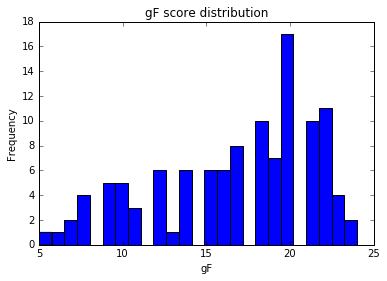

25

In [143]:
# gF score distribution 
n_bins = 2
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(1,50,1)) 

# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits[:-1])

In [144]:
print(bins)

[2 2 1 2 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 1 1 1 1 1 2 2 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 2
 2 2 2 1]


### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

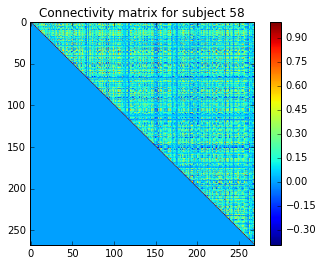

In [45]:
# choose dataset
conn_mats = data['rest_1_mat']
#conn_mats = data['rest_1_mat']
#conn_mats = data_ext

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]
    

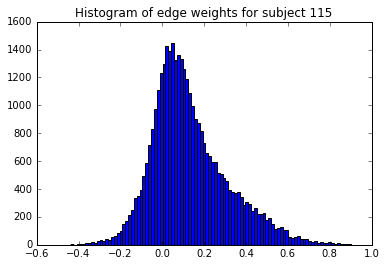

In [8]:
def plt_hist(subject):
    plt.hist(edges[subject-1,], bins=100)
    plt.title('Histogram of edge weights for subject '+str(subject))
    plt.show()


interact(plt_hist, subject=(1,n_subj),continuous_update=False)    

In [54]:
# two tailed percentile
top = 1;
filter_edges = {}
for subject in range(n_subj):
    idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]>=0])
    idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]<=0])
    perc_pos = np.percentile(edges[subject,idx_filtered_pos], 100 - top)
    perc_neg = np.percentile(edges[subject,idx_filtered_neg], top)
    idx_filtered = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]>=perc_pos or edges[subject,idx]<=perc_neg])
    filter_edges[subject] = idx_filtered

In [50]:
# absolute value threshold
top = 1;
filter_edges = {}
for subject in range(n_subj):
    perc = np.percentile(abs(edges[subject,:]), 100 - top)
    idx_filtered = np.array([idx for idx in range(1,n_edges) if abs(edges[subject,idx])>=perc])
    filter_edges[subject] = idx_filtered

### Jaccard Similarity

In [56]:
distmat = np.zeros([n_subj,n_subj])
for i in range(n_subj):
    for j in range(n_subj):
        if(i<j):
            distmat[i,j] = distmat[j,i] = 1 - jaccard_similarity(np.array(filter_edges[i]), np.array(filter_edges[j]))
        

In [29]:
idx_filtered = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]>=perc_pos])
print(len(idx_filtered))

276


In [30]:
idx_filtered = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]<=perc_neg])
print(len(idx_filtered))

83


### Tanimoto distance

In [ ]:
distmat = np.zeros([n_subj,n_subj])
for i in range(n_subj):
    for j in range(n_subj):
        if(i<j):
            distmat[i,j] = distmat[j,i] = 1 - tanimoto(np.array(filter_edges[i]), np.array(filter_edges[j]))
        
        

### Weighted Tanimoto distance

In [149]:
distmat = np.zeros([n_subj,n_subj])
for i in range(n_subj):
    for j in range(n_subj):
        if(i<j):
            distmat[i,j] = distmat[j,i] = 1 - weighted_tanimoto(np.array(filter_edges[i]), np.array(filter_edges[j]))
        
        

## Jaccard 

### MDS

In [88]:
print(distmat.min(), distmat.max(), distmat.mean())

0.0 0.935157644259 0.774053486973


#### Finn's data

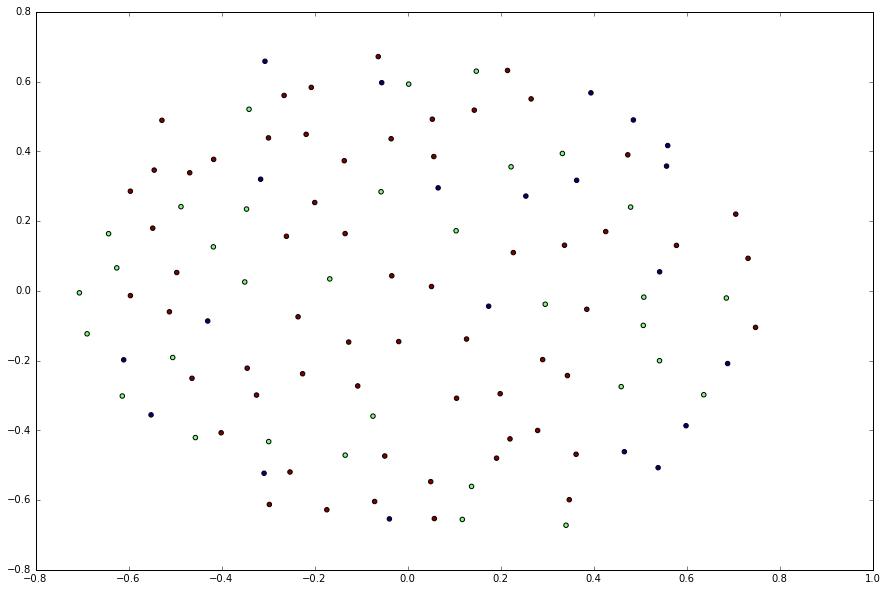

In [57]:
mds = manifold.MDS(n_components=2,dissimilarity='precomputed')
results = mds.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

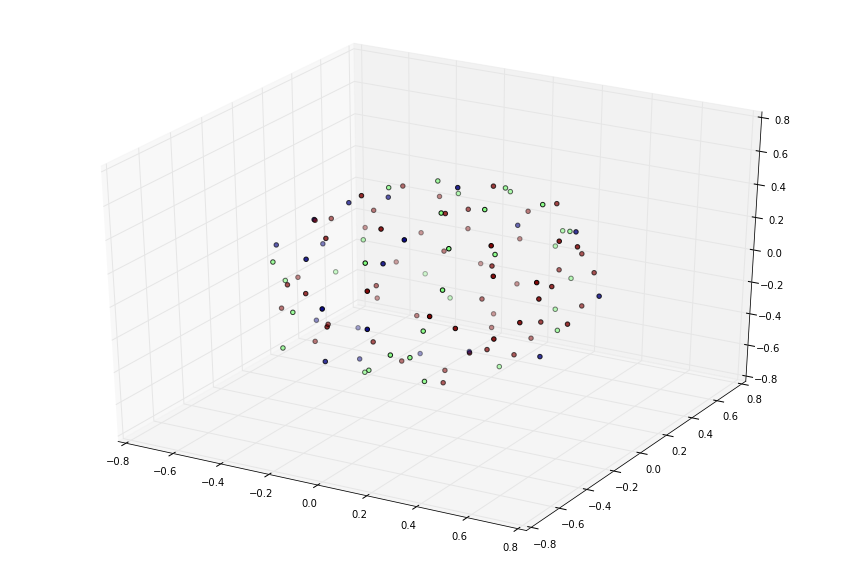

In [90]:
mds = manifold.MDS(n_components=3,dissimilarity='precomputed')
results = mds.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

#### Rest 1

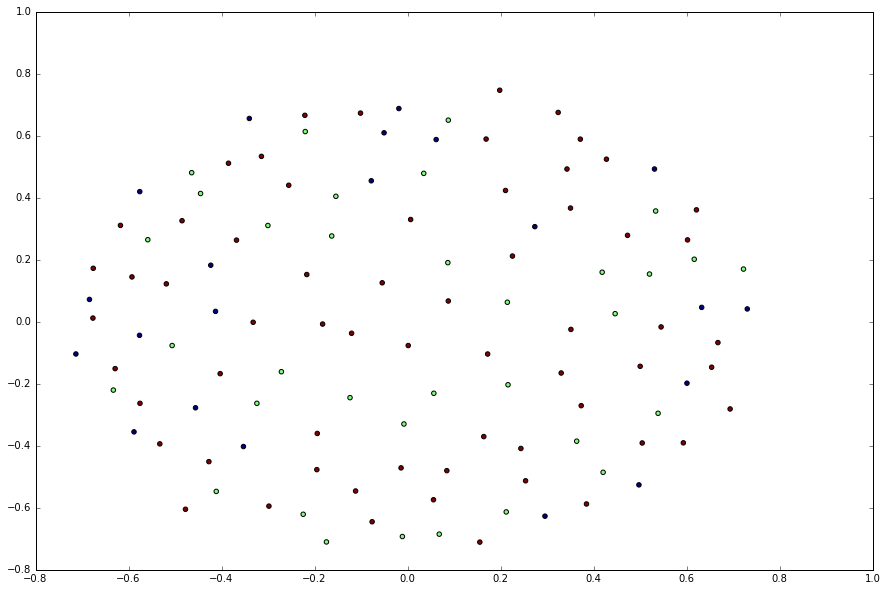

In [98]:
mds = manifold.MDS(n_components=2,dissimilarity='precomputed')
results = mds.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

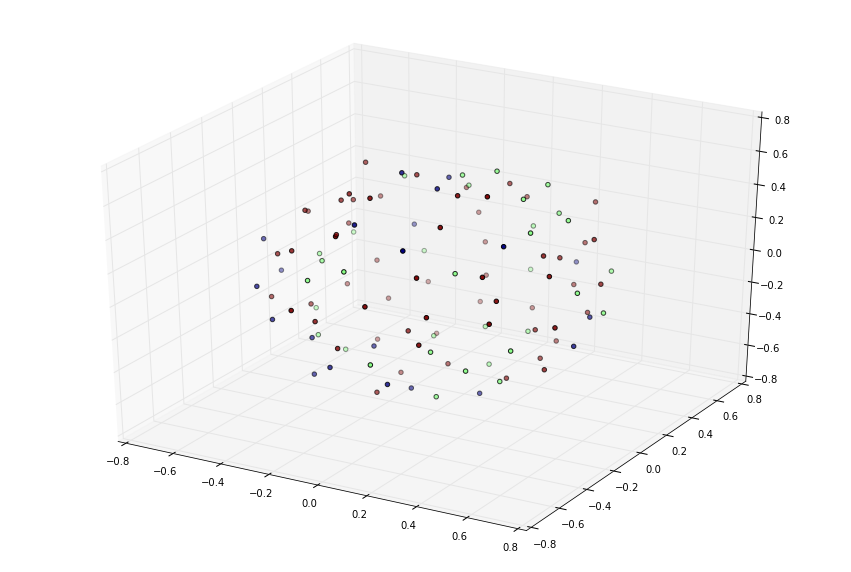

In [99]:
mds = manifold.MDS(n_components=3,dissimilarity='precomputed')
results = mds.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

### TSNE

#### Finn's data

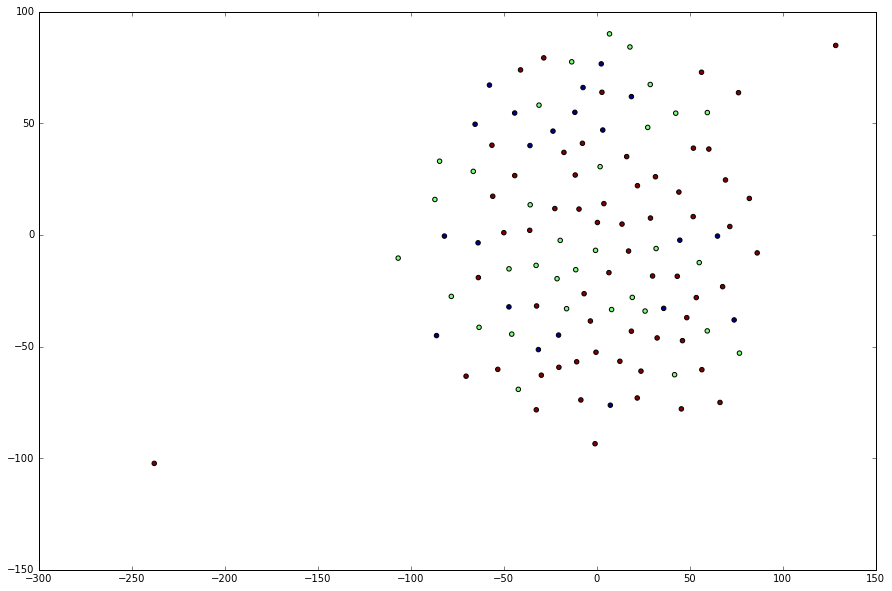

In [91]:
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

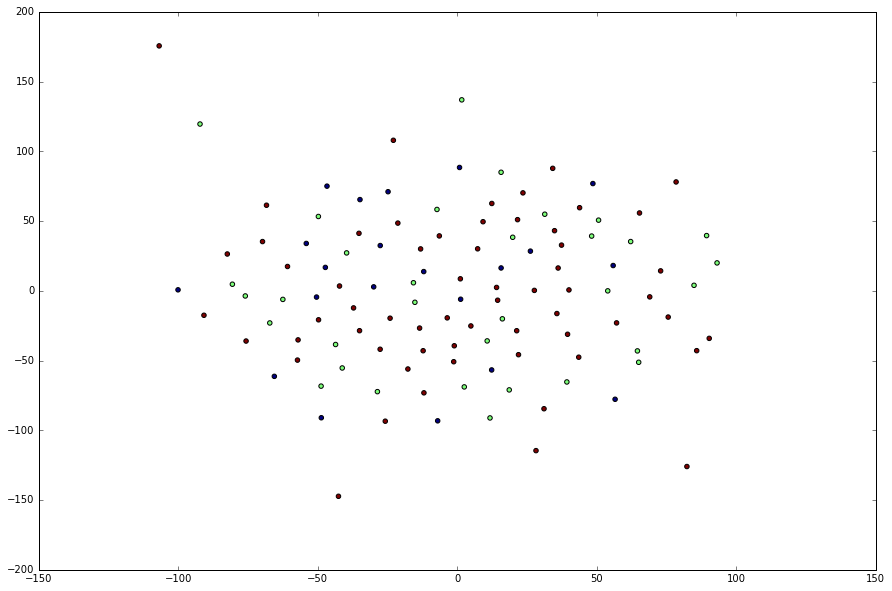

In [141]:
#1 percent
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

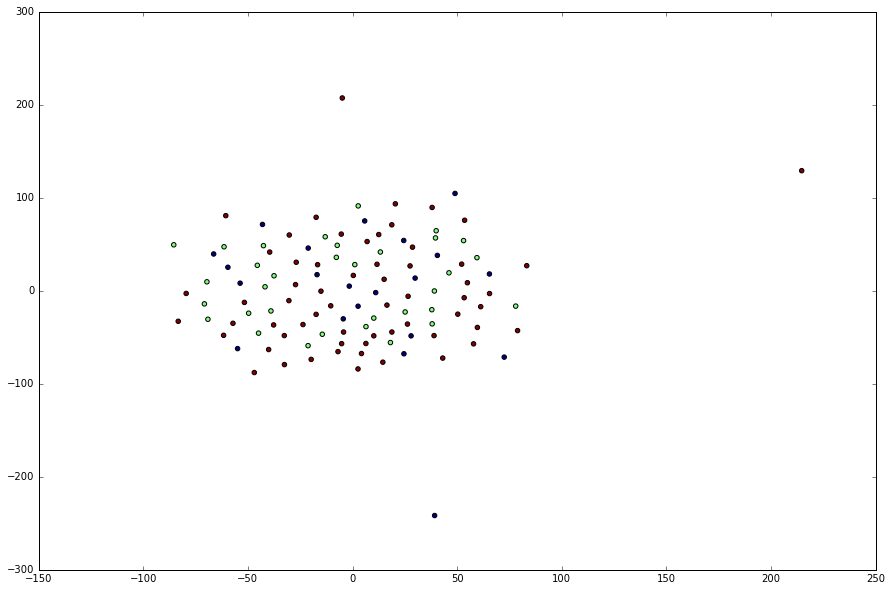

In [26]:
# 3 percent
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

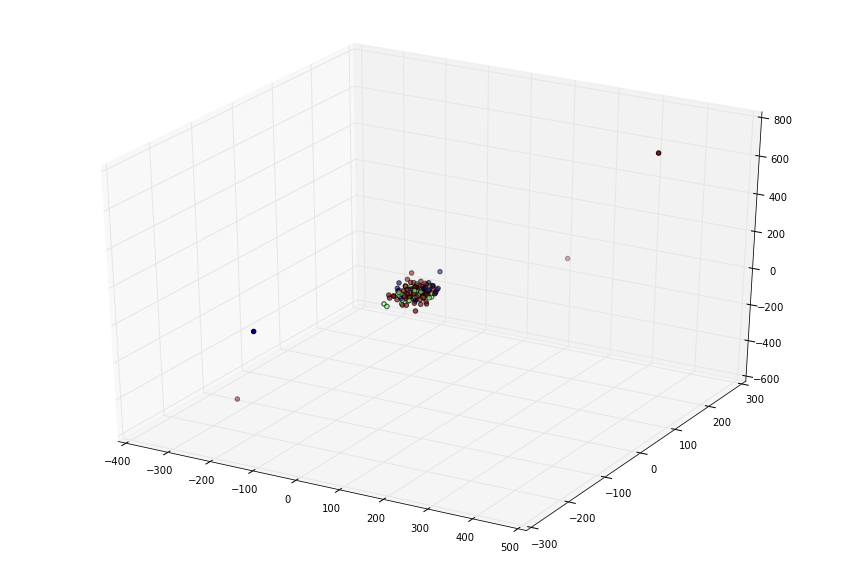

In [92]:
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

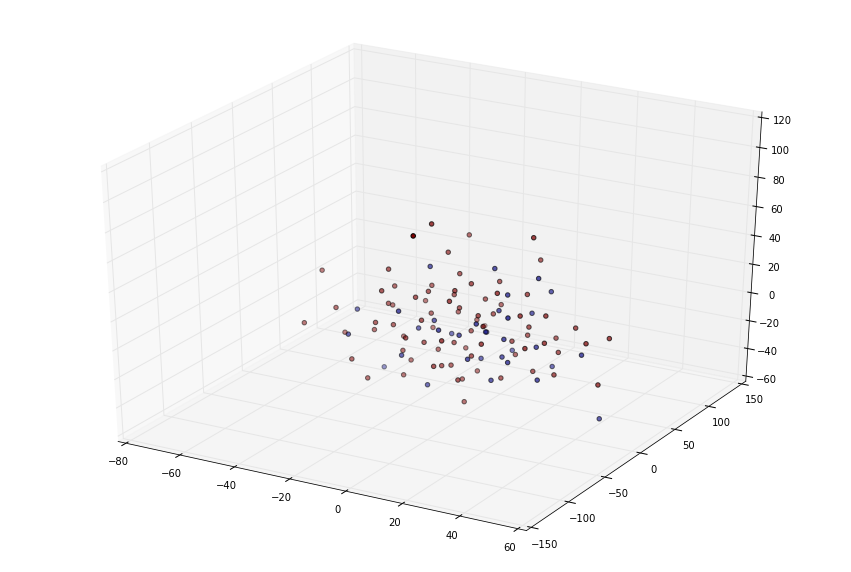

In [39]:
# 1 percent
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

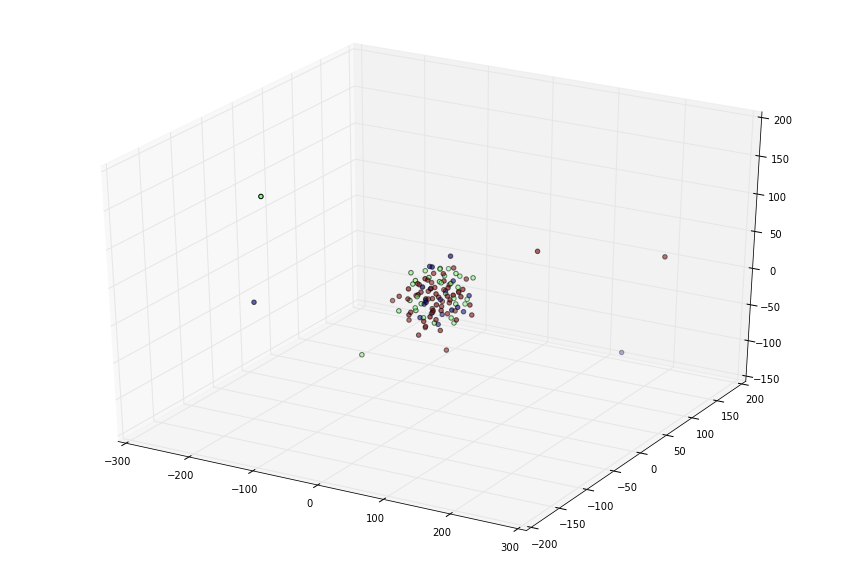

In [27]:
#3 percent
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

#### Rest1

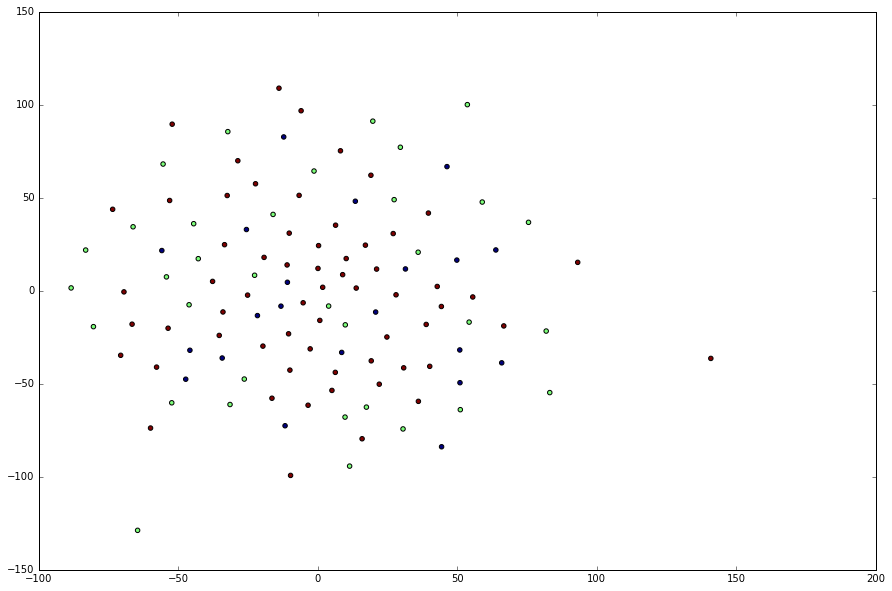

In [100]:
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

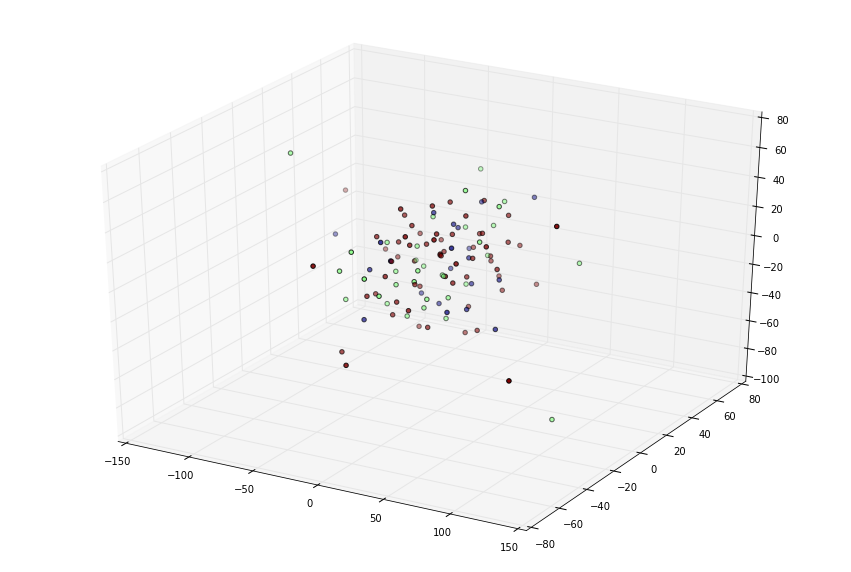

In [101]:
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

## Tanimoto

### TSNE

#### Finn's data

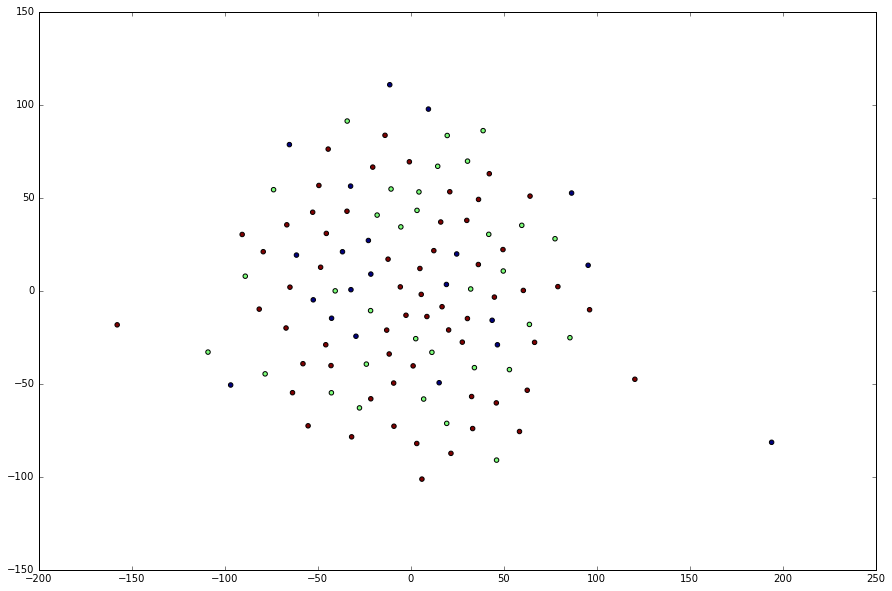

In [157]:
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

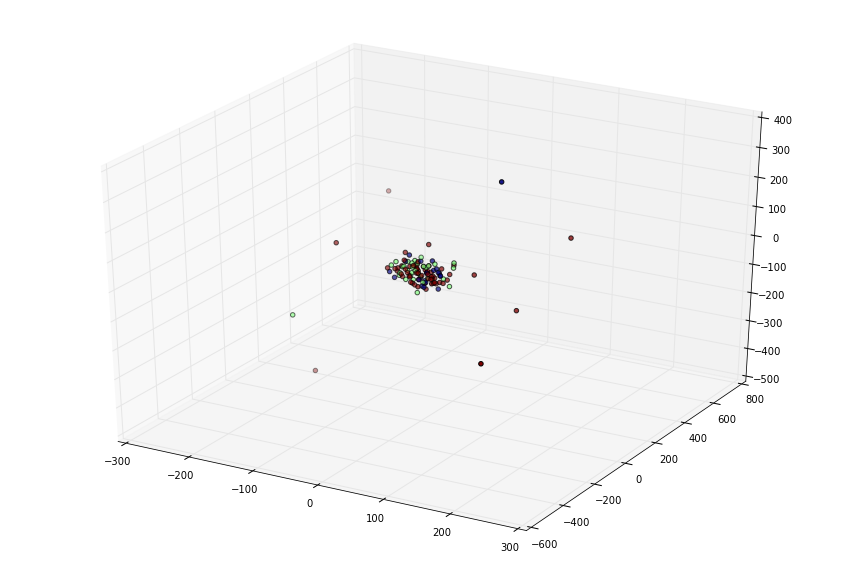

In [158]:
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

#### Rest1

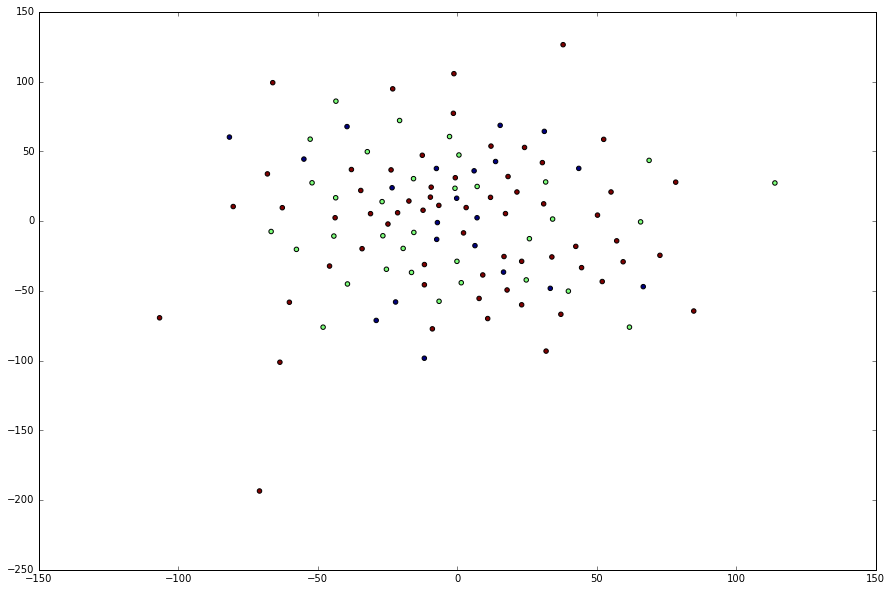

In [173]:
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

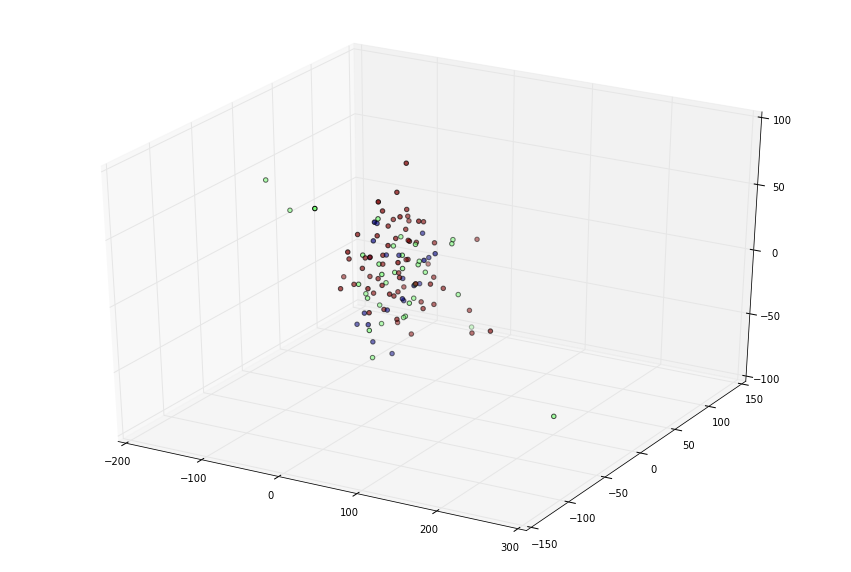

In [174]:
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

#### Extended data set

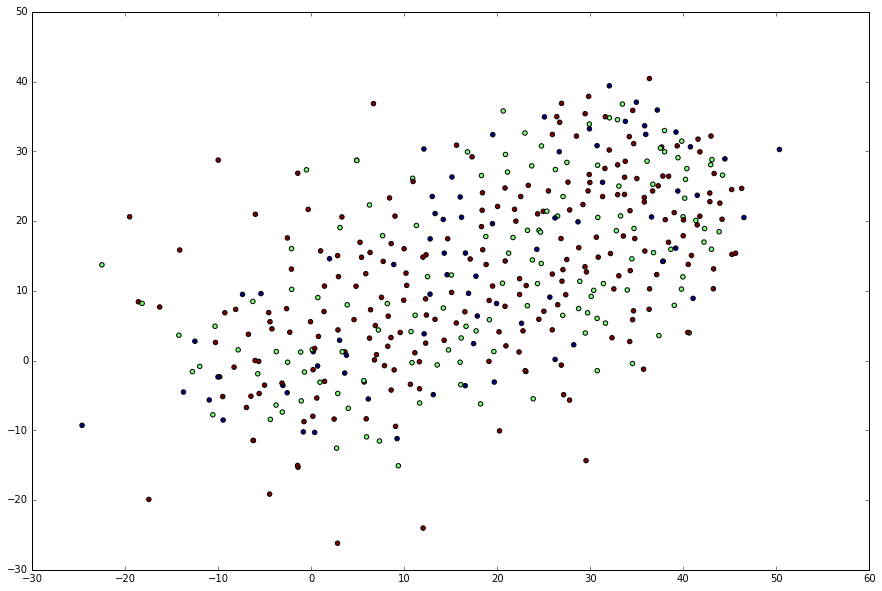

In [150]:
tsne = manifold.TSNE(n_components=2,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
plt.figure(figsize=(15, 10))
plt.scatter(coords[:,0],coords[:,1],c=bins)

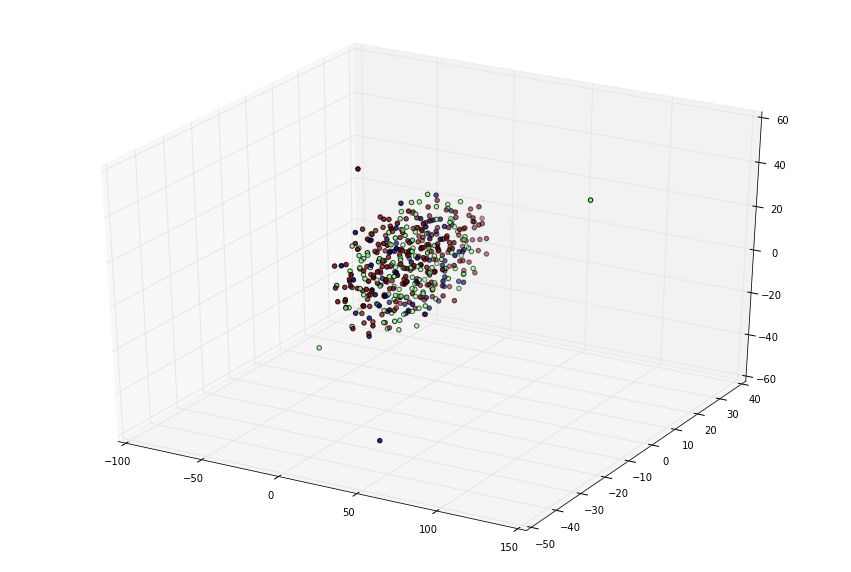

In [151]:
tsne = manifold.TSNE(n_components=3,metric='precomputed')
results = tsne.fit(distmat)
coords = results.embedding_
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0],coords[:,1],coords[:,2],c=bins)

### kNN

In [ ]:
loo = cross_validation.LeaveOneOut(n_subj)
errors = np.zeros([n_subj,1])
predictions = np.zeros([n_subj,1])
prob = np.zeros([n_subj,n_bins])
estimator = KNeighborsClassifier(n_neighbors=5)

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    estimator.fit(coords[train_index,],bins[train_index])
    predictions[i] = estimator.predict(coords[test_index,])
    prob[i,] = estimator.predict_proba(coords[test_index,])
    errors[i] = 1 if predictions[i]==bins[test_index] else 0
    i += 1
    f.value += 1
        

In [165]:
loo = cross_validation.LeaveOneOut(n_subj)

predictions = np.zeros([n_subj,1])
dist = DistanceMetric.get_metric('euclidean')
estimator = KNeighborsClassifier(n_neighbors=5,metric=lambda a,b: jaccard_distance(a,b))
I = np.zeros(edges.shape)

top = 5
filter_edges = {}
for subject in range(n_subj):
    idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]>=0])
    idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]<=0])
    perc_pos = np.percentile(edges[subject,idx_filtered_pos], 100 - top)
    perc_neg = np.percentile(edges[subject,idx_filtered_neg], top)
    idx_filtered = np.array([idx for idx in 
                             range(1,n_edges) if edges[subject,idx]>=perc_pos or edges[subject,idx]<=perc_neg])
    I[subject,idx_filtered] = 1

i=0
f = FloatProgress(min=0, max=n_subj)
display(f)
for train_index, test_index in loo:
    estimator.fit(I[train_index,],bins[train_index])
    predictions[i] = estimator.predict(I[test_index,])
    i += 1
    f.value += 1
        

[[ 5  8  8]
 [ 5  9 19]
 [ 8 12 41]]
Accuracy: 0.478260869565
             precision    recall  f1-score   support

          1       0.28      0.24      0.26        21
          2       0.31      0.27      0.29        33
          3       0.60      0.67      0.64        61

avg / total       0.46      0.48      0.47       115



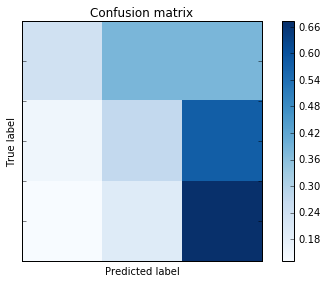

In [66]:
y_pred = predictions
y_true = bins
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 0 34]
 [ 0 81]]
Accuracy: 0.704347826087
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        34
          2       0.70      1.00      0.83        81

avg / total       0.50      0.70      0.58       115



C:\Users\Paola\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


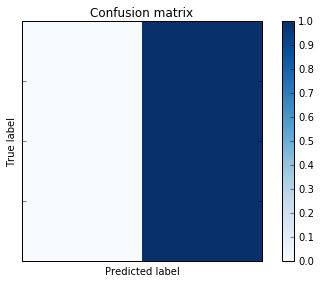

In [166]:
#knn without dr
y_pred = predictions
y_true = bins
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

In [149]:
# two tailed threshold
tops = np.array([1,3,5,10,20])

results1 = {}
results3 = {}
results5 = {}

for top in tops:
    
    filter_edges = {}
    for subject in range(n_subj):
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]>=0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if edges[subject,idx]<=0])
        perc_pos = np.percentile(edges[subject,idx_filtered_pos], 100 - top)
        perc_neg = np.percentile(edges[subject,idx_filtered_neg], top)
        idx_filtered = np.array([idx for idx in 
                                 range(1,n_edges) if edges[subject,idx]>=perc_pos or edges[subject,idx]<=perc_neg])
        filter_edges[subject] = idx_filtered
    
    distmat = np.zeros([n_subj,n_subj])
    for i in range(n_subj):
        for j in range(n_subj):
            if(i<j):
                distmat[i,j] = distmat[j,i] = 1 - jaccard_similarity(np.array(filter_edges[i]), np.array(filter_edges[j]))    

    tsne = manifold.TSNE(n_components=3,metric='precomputed')
    res = tsne.fit(distmat)
    coords = res.embedding_
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=1)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results1[top] = predictions
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=3)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results3[top] = predictions
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=5)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results5[top] = predictions


In [145]:
# absolute value threshold
tops = np.array([1,3,5,10,20])

results1 = {}
results3 = {}
results5 = {}

for top in tops:
    
    filter_edges = {}
    for subject in range(n_subj):
        perc = np.percentile(abs(edges[subject,:]), 100 - top)
        idx_filtered = np.array([idx for idx in range(1,n_edges) if abs(edges[subject,idx])>=perc])
        filter_edges[subject] = idx_filtered
    
    distmat = np.zeros([n_subj,n_subj])
    for i in range(n_subj):
        for j in range(n_subj):
            if(i<j):
                distmat[i,j] = distmat[j,i] = 1 - jaccard_similarity(np.array(filter_edges[i]), np.array(filter_edges[j]))    

    tsne = manifold.TSNE(n_components=3,metric='precomputed')
    res = tsne.fit(distmat)
    coords = res.embedding_
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=1)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results1[top] = predictions
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=3)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results3[top] = predictions
    
    loo = cross_validation.LeaveOneOut(n_subj)
    predictions = np.zeros([n_subj,1])
    estimator = KNeighborsClassifier(n_neighbors=5)

    i=0
    for train_index, test_index in loo:
        estimator.fit(coords[train_index,],bins[train_index])
        predictions[i] = estimator.predict(coords[test_index,])
        i += 1
    
    results5[top] = predictions


In [153]:
acc1 = np.zeros([5])
acc3 = np.zeros([5])
acc5 = np.zeros([5])

for i in range(5):
    y_pred = results1[tops[i]]
    acc1[i] = accuracy_score(bins, y_pred)
    y_pred = results3[tops[i]]
    acc3[i] = accuracy_score(bins, y_pred)
    y_pred = results5[tops[i]]
    acc5[i] = accuracy_score(bins, y_pred)


In [151]:
acc1 = np.zeros([5])
acc3 = np.zeros([5])
acc5 = np.zeros([5])

for i in range(5):
    y_pred = results1[tops[i]]
    acc11[i] = accuracy_score(bins, y_pred)
    y_pred = results3[tops[i]]
    acc33[i] = accuracy_score(bins, y_pred)
    y_pred = results5[tops[i]]
    acc55[i] = accuracy_score(bins, y_pred)


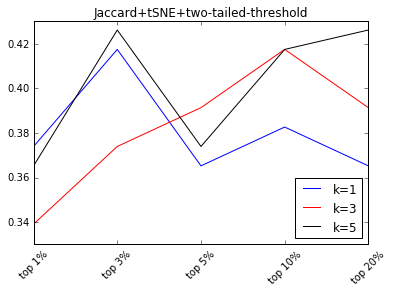

In [124]:
x = [1,2,3,4,5]
a, = plt.plot(x,acc1,'b', label='k=1')
b, = plt.plot(x,acc3,'r', label='k=3')
c, = plt.plot(x,acc5,'k', label='k=5')
labels = ['top 1%','top 3%','top 5%', 'top 10%', 'top 20%']
plt.xticks(x, labels, rotation=45)
plt.legend(handles=[a, b, c], loc=4)
plt.title('Jaccard+tSNE+two-tailed-threshold')

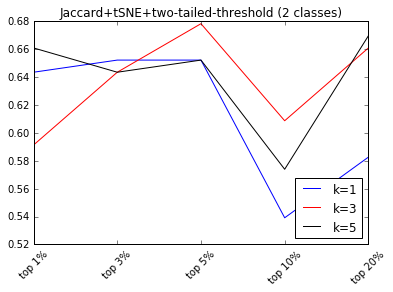

In [154]:
x = [1,2,3,4,5]
a, = plt.plot(x,acc1,'b', label='k=1')
b, = plt.plot(x,acc3,'r', label='k=3')
c, = plt.plot(x,acc5,'k', label='k=5')
labels = ['top 1%','top 3%','top 5%', 'top 10%', 'top 20%']
plt.xticks(x, labels, rotation=45)
plt.legend(handles=[a, b, c], loc=4)
plt.title('Jaccard+tSNE+two-tailed-threshold (2 classes)')

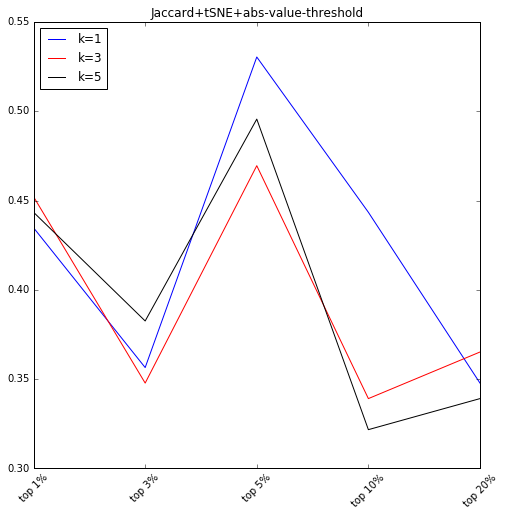

In [142]:
x = [1,2,3,4,5]
fig = plt.figure(figsize=(8, 8))
a, = plt.plot(x,acc11,'b', label='k=1')
b, = plt.plot(x,acc33,'r', label='k=3')
c, = plt.plot(x,acc55,'k', label='k=5')
labels = ['top 1%','top 3%','top 5%', 'top 10%', 'top 20%']
plt.xticks(x, labels, rotation=45)
plt.legend(handles=[a, b, c], loc=2)
plt.title('Jaccard+tSNE+abs-value-threshold')

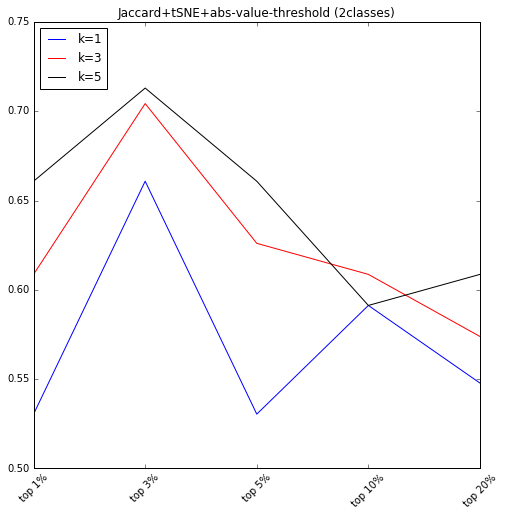

In [147]:
x = [1,2,3,4,5]
fig = plt.figure(figsize=(8, 8))
a, = plt.plot(x,acc11,'b', label='k=1')
b, = plt.plot(x,acc33,'r', label='k=3')
c, = plt.plot(x,acc55,'k', label='k=5')
labels = ['top 1%','top 3%','top 5%', 'top 10%', 'top 20%']
plt.xticks(x, labels, rotation=45)
plt.legend(handles=[a, b, c], loc=2)
plt.title('Jaccard+tSNE+abs-value-threshold (2classes)')

[[ 6  5 10]
 [ 5 22  6]
 [14 14 33]]
Accuracy: 0.530434782609
             precision    recall  f1-score   support

          1       0.24      0.29      0.26        21
          2       0.54      0.67      0.59        33
          3       0.67      0.54      0.60        61

avg / total       0.56      0.53      0.54       115



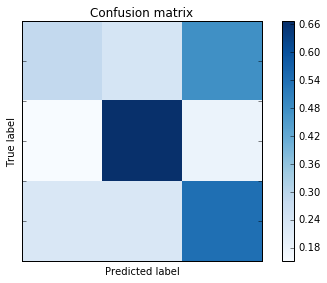

In [140]:
y_pred = results1[5]
y_true = bins
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[11 23]
 [10 71]]
Accuracy: 0.713043478261
             precision    recall  f1-score   support

          1       0.52      0.32      0.40        34
          2       0.76      0.88      0.81        81

avg / total       0.69      0.71      0.69       115



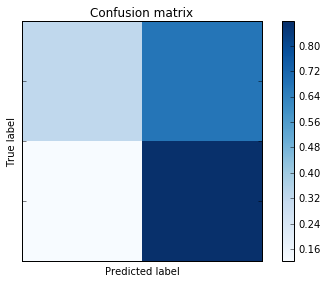

In [148]:
y_pred = results5[3]
y_true = bins
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[11 23]
 [14 67]]
Accuracy: 0.678260869565
             precision    recall  f1-score   support

          1       0.44      0.32      0.37        34
          2       0.74      0.83      0.78        81

avg / total       0.65      0.68      0.66       115



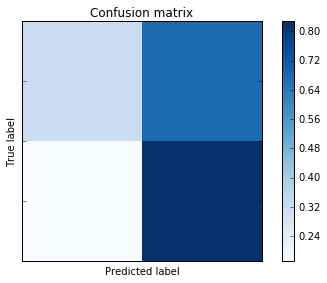

In [155]:
y_pred = results3[5]
y_true = bins
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized)
print(cm)
print('Accuracy:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

In [135]:
tosave = {'res1':acc1,'res3':acc3, 'res5':acc5}
sio.savemat('knn_jaccard_tsne_2tailed.mat',tosave)

In [136]:
tosave = {'res1':acc11,'res3':acc33, 'res5':acc55}
sio.savemat('knn_jaccard_tsne_abs.mat',tosave)